# 05-2 교차 검증과 그리드 서치

"이런저런 값으로 모델을 많이 만들어서 테스트 세트로 평가하면 결국 테스트 세트에 잘 맞는 모델이 만들어지는 것 아닌가요?"

## 검증 세트

테스트 세트를 사용하지 않으면 모델이 과대적합인지 과소적합인지 판단하기 어렵습니다. 테스트 세트를 사용하지 않고 이를 측정하는 간단한 방법은 훈련 세트를 또 나누는거죠! 이 데이터를 **검증 세트**validation set라고 부릅니다.

훈련 세트 60%, 검증 세트 20%, 테스트 세트 20%

훈련 세트에서 모델을 훈련하고 검증 세트로 모델을 평가합니다. 이런식으로 테스트하고 싶은 매개변수를 바꿔가며 가장 좋은 모델을 고릅니다. 그다음 이 매개변수를 사용해 훈련 세트와 검증 세트를 합쳐 전체 훈련 데이터에서 모델을 다시 훈련합니다. 그리고 마지막에 테스트 세트에서 최종 점수를 평가합니다. 아마도 실전에 투입했을 때 테스트 세트의 점수와 비슷한 성능을 기대할 수 있을 것입니다.

그럼 이전 절에 사용했던 데이터를 다시 불러와서 검증 세트를 만들어 보겠습니다.

In [1]:
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [2]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

이제 훈련 세트와 테스트 세트를 나눌 차례입니다. 방식은 이전과 동일합니다. 훈련 세트의 입력 데이터와 타깃 데이터를 train_input과 train_target 배열에 저장합니다.

In [3]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)

그다음 train_input과 train_target을 다시 train_test_split() 함수에 넣어 훈련 세트 sub_input, sub_target고 검증 세트 val_input, val_target을 만듭니다. 여기에서도 test_size 매개변수를 0.2로 지정하면 train_input의 약 20%를 val_input으로 만듭니다.

In [4]:
sub_input, val_input, sub_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

훈련 세트와 검증 세트의 크기를 확인해 보죠.

In [5]:
sub_input.shape, val_input.shape

((4157, 3), (1040, 3))

이제 sub_input, sub_target과 val_input, val_target을 사용해 모델을 만들고 평가해 보겠습니다.

In [6]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(sub_input, sub_target)
print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


이 모델은 확실히 훈련 세트에 과대적합되어 있군요. 매개변수를 바꿔서 더 좋은 모델을 찾아야 합니다. 그 전에 검증 세트에 관해 좀 더 알아야 할 것이 있습니다.

## 교차 검증

검증 세트를 만드느라 훈련 세트가 줄었습니다. 보통 많은 데이터를 훈련에 사용할수록 좋은 모델이 만들어집니다. 그렇다고 검증 세트를 너무 조금 떼어놓으면 검증 점수가 들쭉날쭉하고 불안정할 것입니다. 이럴 때 **교차 검증**cross validation을 이용하면 안정적인 검증 점수를 얻고 훈련에 더 많은 데이터를 사용할 수 있습니다.

교차 검증은 검증 세트를 떼어 내어 평가하는 과정을 여러 번 반복합니다. 그다음 이 점수를 평균하여 최종 검증 점수를 얻습니다. 이 과정을 그림으로 보면 이해가 쉽습니다. 다음은 3-폴드 교차 검증 그림입니다.

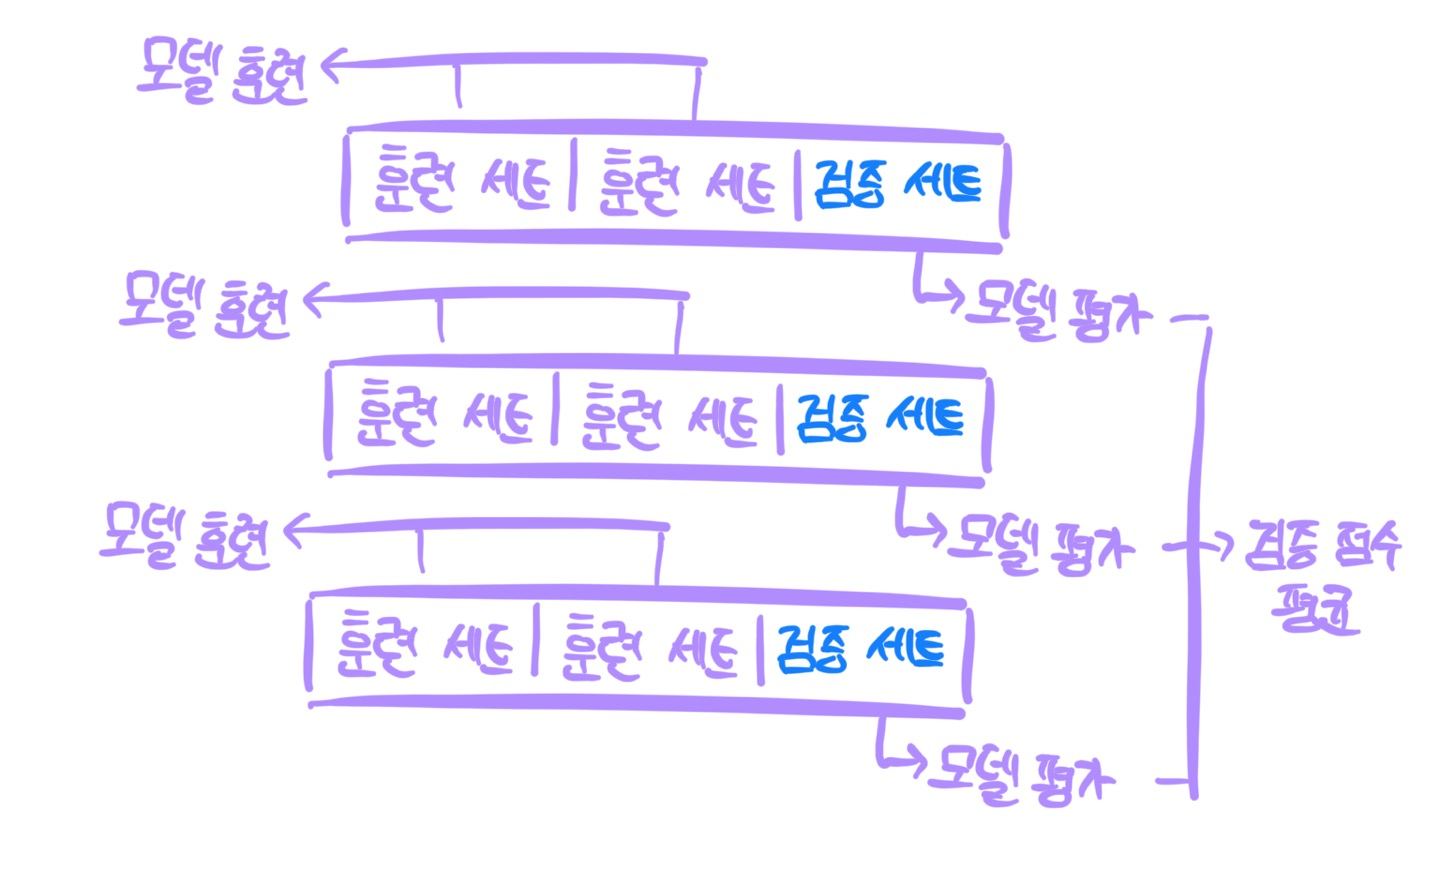

보통 5-폴드 교차 검증이나 10-폴드 교차 검증을 많이 사용합니다. 이렇게 하면 데이터의 80~90%까지 훈련에 사용할 수 있습니다. 검증 세트가 줄어들지만 각 폴드에서 계산한 검증 점수를 평균하기 때문에 안정된 점수로 생각할 수 있습니다.

사이킷런에는 cross_validate()라는 교차 검증 함수가 있습니다. 사용법은 간단한데, 먼저 평가할 모델 객체를 첫 번째 매개변수로 전달합니다. 그다음 앞에서처럼 직접 검증 세트를 떼어 내지 않고 훈련 세트 전체를 cross_validate() 함수에 전달합니다.

In [7]:
from sklearn.model_selection import cross_validate
scores = cross_validate(dt, train_input, train_target)
scores

{'fit_time': array([0.00699759, 0.00651145, 0.00599599, 0.00599694, 0.00599909]),
 'score_time': array([0.        , 0.        , 0.00100303, 0.00100207, 0.00099993]),
 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}

이 함수는 fit_time, score_time, test_score 키를 가진 딕셔너리를 반환합니다. 처음 2개의 키는 각각 모델을 훈련하는 시간과 검증하는 시간을 의미합니다. 각 키마다 5개의 숫자가 담겨 있습니다. cross_validate() 함수는 기본적으로 5-폴드 교차 검증을 수행합니다. cv 매개변수에서 폴드 수를 바꿀 수도 있습니다.

교차 검증의 최종 점수는 test_score 키에 담기 5개의 점수를 평균하여 얻을 수 있습니다. 이름은 test_score지만 검증 폴드의 점수입니다. 혼동하지 마세요

In [8]:
import numpy as np
np.mean(scores['test_score'])

0.855300214703487

교차 검증을 수행하면 입력한 모델에서 얻을 수 있는 최상의 검증 점수를 가늠해 볼 수 있습니다.

한 가지 주의할 점은 cross_validate()는 훈련 세트를 섞어 폴드를 나누지 않습니다. 앞서 우리는 train_test_split() 함수로 전체 데이터를 섞은 후 훈련 세트를 준비했기 때문에 따로 섞을 필요가 없습니다. 하지만 만약 교차 검증을 할 때 훈련 세트를 섞으려면 분할기splitter를 지정해야 합니다.

사이킷런의 분할기는 교차 검증에서 폴드를 어떻게 나눌지 결정해 줍니다. cross_validate() 함수는 기본적으로 회귀 모델일 경우 KFold 분할기를 사용하고 분류 모델일 경우 타깃 클래스를 골고루 나누기 위해 StratifiedKFold를 사용합니다. 즉 앞서 수행한 교차 검증은 다음 코드와 동일합니다.

In [9]:
from sklearn.model_selection import StratifiedKFold
scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
np.mean(scores['test_score'])

0.855300214703487

만약 훈련 세트를 섞은 후 10-폴드 교차 검증을 수행하려면 다음과 같이 작성합니다.

In [10]:
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
np.mean(scores['test_score'])

0.8574181117533719

KFold 클래스도 동일한 방식으로 사용할 수 있습니다. 이어서 결정 트리의 매개변수 값을 바꿔가며 가장 좋은 성능이 나오는 모델을 찾아 보겠습니다. 이때 테스트 세트를 사용하지 않고 교차 검증을 통해 좋은 모델을 고르면 됩니다.

## 하이퍼파라미터 튜닝

모델이 학습할 수 없어서 사용자가 지정해야만 하는 파라미터를 하이퍼파라미터라고 합니다. 사이킷런과 같은 머신러닝 라이브러리를 사용할 때 이런 하이퍼파라미터는 모두 클래스나 메서드의 매개변수로 표현됩니다.

먼저 라이브러리가 제공하는 기본값을 그대로 사용해 모델을 훈련합니다. 그다음 검증 세트의 점수나 교차 검증을 통해서 매개변수를 조금씩 바꿔봅니다. 모델마다 적게는 1~2개에서, 많게는 5~6개의 매개변수를 제공합니다. 이 매개변수를 바꿔가면서 모델을 훈련하고 교차 검증을 수행해야 하죠.

> 사람의 개입 없이 하이퍼파라미터 튜닝을 자동으로 수행하는 기술을 'AutoML'이라고 부릅니다.

그런데 아주 중요한 점이 있습니다. 가령 결정 트리 모델에서 최적의 max_depth 값을 찾았다고 가정해 봅시다. 그다음 max_depth를 최적의 값으로 고정하고 min_samples_split을 바꿔가며 최적의 값을 찾습니다. 이렇게 한 매개변수의 최적값을 찾고 다른 매개변수의 최적값을 찾아도 될까요? 아니요, 틀렸습니다. 불행하게도 max_depth의 최적값은 min_samples_split 매개변수의 값이 바뀌면 함께 달라집니다. 즉 이 두 매개변수를 동시에 바꿔가며 최적의 값을 찾아야 하는 거죠!

파이썬의 for 반복문으로 이런 과정을 직접 구현할 수도 있지만, 사이킷런에서 제공하는 **그리드 서치**Grid Search를 사용합시다.

사이킷런의 GridSearchCV 클래스는 친절하게도 하이퍼파라미터 탐색과 교차 검증을 한 번에 수행합니다. 별도로 cross_validate() 함수를 호출할 필요가 없죠. 기본 매개변수를 사용한 결정 트리 모델에서 in_impurity_decrease 매개변수의 최적값을 찾아보겠습니다. 먼저 GridSearchCV 클래스를 임포트하고 탐색할 매개변수와 탐색할 값의 리스트를 딕셔너리로 만듭니다.

In [11]:
from sklearn.model_selection import GridSearchCV
params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

GridSearchCV 클래스에 탐색 대상 모델과 params 변수를 전달하여 그리드 서치 객체를 만듭니다.

In [12]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)

결정 트리 클래스의 객체를 생성하자마자 바로 전달했습니다.  그다음 일반 모델을 훈련하는 것처럼 gs 객체에 fit() 메서드를 호출합니다. 이 메서드를 호출하면 그리드 서치 객체는 결정 트리 모델 min_impurity_decrease 값을 바꿔가며 총 5번 실행합니다.

GridSearchCV의 cv 매개변수 기본값은 5입니다. 따라서 min_impurity_decrease 값마다 5-폴드 교차 검증을 수행합니다. 결국 5×5=25개의 모델을 훈련합니다! 많은 모델을 훈련하기 때문에 GridSearchCV 클래스의 n_jobs 매개변수에서 병렬 실행에 사용할 CPU 코어 수를 지정하는 것이 좋습니다. 이 매개변수의 기본값은 1입니다. -1로 지정하면 시스템에 있는 모든 코어를 사용합니다. 그럼 그리드 서치를 수행해 보죠.

In [13]:
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

교차 검증에서 최적의 하이퍼파라미터를 찾으면 전체 훈련 세트로 모델을 다시 만들어야 한다고 했던 것을 기억하나요? 아주 편리하게도 사이킷런의 그리드 서치는 훈련이 끝나면 25개의 모델 중에서 검증 점수가 가장 높은 모델의 매개변수 조합으로 전체 훈련 세트에서 자동으로 다시 모델을 훈련합니다. 이 모델은 gs 객체의 best_estimator_ 속성에 저장되어 있습니다. 이 모델을 일반 결정트리 처럼 똑같이 사용할 수 있습니다.

In [14]:
dt = gs.best_estimator_
dt.score(train_input, train_target)

0.9615162593804117

그리드 서치로 찾은 최적의 매개변수는 best_params_ 속성에 저장되어 있습니다.

In [15]:
gs.best_params_

{'min_impurity_decrease': 0.0001}

여기서는 0.0001이 가장 좋은 값으로 선택되었습니다. 각 매개변수에서 수행한 교차 검증의 평균 점수는 cv_results_ 속성의 'mean_test_score' 키에 저장되어 있습니다. 5번의 교차 검증으로 얻은 점수를 출력해 보죠. 

In [16]:
gs.cv_results_['mean_test_score']

array([0.86819297, 0.86453617, 0.86492226, 0.86780891, 0.86761605])

첫 번째 값이 가장 큰 것 같군요. 수동으로 고르는 것보다 넘파이 argmax() 함수를 사용하면 가장 큰 값의 인덱스를 추출할 수 있습니다. 그다음 이 인덱스를 사용해 params 키에 저장된 매개변수를 출력할 수 있습니다. 이 값이 최상의 검증 점수를 만든 매개변수 조합입니다. 앞에서 출력한 gs.best_params_와 동일한지 확인해 보세요.

In [17]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
gs.cv_results_['params'][best_index]

{'min_impurity_decrease': 0.0001}

이 과정을 정리해 보겠습니다.
1. 먼저 탐색할 매개변수를 지정합니다.
2. 그다음 훈련 세트에서 그리드 서치를 수행하여 최상의 평균 검증 점수가 나오는 매개변수 조합을 찾습니다. 이 조합은 그리드 서치 객체에 저장됩니다.
3. 그리드 서치는 최상의 매개변수에서 (교차 검증에 사용한 훈련 세트가 아니라) 전체 훈련 세트를 사용해 최종 모델을 훈련합니다. 이 모델도 그리드 서치 객체에 저장됩니다.

그럼 조금 더 복잡한 매개변수 조합을 탐색해 볼까요? 결정 트리에서 min_impurity_decrese는 노드를 분할하기 위한 불순도 감소 최소량을 지정합니다. 여기에다가 max_depth로 트리의 깊이를 제한하고 min_samples_split으로 노드를 나누기 위한 최소 샘플 수도 골라보겠습니다.

In [18]:
params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
         'max_depth': range(5, 20, 1),
         'min_samples_split': range(2, 100, 10)}

넘파이 arange() 함수(```np.arange(0.0001, 0.001, 0.0001)```)는 첫 번째 매개변수 값에서 시작하여 두 번째 매개변수에 도달할 때까지 세 번째 매개변수를 계속 더한 배열을 만듭니다. 코드에서는 0.0001에서 시작하여 0.001이 될 때까지 0.0001을 계속 더한 배열입니다. 두 번째 매개변수는 포함되지 않으므로 배열의 원소는 총 9개입니다.

파이썬 range() 함수(```range(5, 20, 1)```, ```range(2, 100, 10)```)도 비슷합니다.

따라서 이 매개변수로 수행할 교차 검증 횟수는 9×15×10=1350개 입니다. 기본 5-폴드 교차 검증을 수행하므로 만들어지는 모델의 수는 6750개나 됩니다! n_jobs 매개변수를 -1로 설정하고 그리드 서치를 실행해 보겠습니다.

In [19]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

최상의 매개변수 조합을 확인해 보겠습니다.

In [20]:
gs.best_params_

{'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}

최상의 교차 검증 점수도 확인해 보겠습니다.

In [22]:
np.max(gs.cv_results_['mean_test_score'])

0.8683865773302731

훌륭합니다. GridSearchCV 클래스를 사용하니 매개변수를 일일이 바꿔가며 교차 검증을 수행하지 않고 원하는 매개변수 값을 나열하면 자동으로 교차 검증을 수행해서 최상의 매개변수를 찾을 수 있습니다.

그런데 아직 조금 아쉬운 점이 있습니다. 앞에서 탐색할 매개변수의 간격을 0.0001 혹은 1로 설정했는데요. 이렇게 간격을 둔 것에 특별한 근거가 없습니다. 이보다 더 좁거나 넓은 간격으로 시도해 볼 수 있지 않을까요?

### 랜덤 서치

매개변수의 값이 수치일 때 값의 범위나 간격을 미리 정하기 어려울 수 있습니다. 또 너무 많은 매개변수 조건이 있어 그리드 서치 수행 시간이 오래 걸릴 수 있습니다. 이럴 때 **랜덤 서치**Random Search를 사용하면 좋습니다.

랜덤 서치에는 매개변수 값의 목록을 전달하는 것이 아니라 매개변수를 샘플링 할 수 있는 확률 분포 객체를 전달합니다. 먼저 싸이파이에서 2개의 확률 분포 클래스를 임포트해 보죠.

> **싸이파이(scipy)는 어떤 라이브러리인가요?**   
> 파이썬의 핵심 과학 라이브러리 중 하나입니다. 적분, 보간, 선형 대수, 확률 등을 포함한 수치 계산 전용 라이브러리입니다. 사이킷런은 넘파이와 싸이파이 기능을 많이 사용합니다.

In [23]:
from scipy.stats import uniform, randint

싸이파이의 stats 서브 패키지에 있는 uniform과 randint 클래스는 모두 주어진 범위에서 고르게 값을 뽑습니다. 이를 '균등 분포에서 샘플링한다'라고 말합니다. randint는 정숫값을 뽑고, uniform은 실숫값을 뽑습니다. 사용하는 방법은 같습니다. 0에서 10 사이의 범위를 갖는 randint 객체를 만들고 10개의 숫자를 샘플링해 보겠습니다.

In [24]:
rgen = randint(0, 10)
rgen.rvs(10)

array([4, 1, 8, 9, 9, 7, 3, 6, 1, 6])

1000개를 샘플링해서 각 숫자의 개수를 세어 보겠습니다.

In [25]:
np.unique(rgen.rvs(1000), return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 84, 119,  99,  98,  98, 106, 103, 110,  92,  91], dtype=int64))

개수가 늘어나니 0에서 9까지의 숫자가 어느 정도 고르게 추출된 것을 볼 수 있습니다. uniform 클래스의 사용법도 동일합니다. 0~1 사이에서 10개의 실수를 추출해 보겠습니다.

In [26]:
ugen = uniform(0, 1)
ugen.rvs(10)

array([0.92593058, 0.0520975 , 0.64938788, 0.83614847, 0.9493069 ,
       0.15321108, 0.82945953, 0.0241565 , 0.84903407, 0.48074001])

난수 발생기랑 유사하게 생각하면 됩니다. 랜덤 서치에 randint과 uniform 클래스 객체를 넘겨주고 총 몇 번을 샘플링해서 최적의 매개변수를 찾으라고 명령할 수 있습니다. 샘플링 횟수는 시스템 자원이 허락하는 범위 내에서 최대한 크게 하는 것이 좋겠죠.

그럼 탐색할 매개변수의 딕셔너리를 만들어 보겠습니다. 여기에서는 min_samples_leaf 매개변수를 탐색 대상에 추가하겠습니다. 이 매개변수는 리프 노드가 되기 위한 최소 샘플의 개수입니다. 어떤 노드가 분할하여 만들어질 자식 노드의 샘플 수가 이 값보다 작을 경우 분할하지 않습니다.

In [27]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
         'max_depth': randint(20, 50),
         'min_samples_split': randint(2, 25),
         'min_samples_leaf': randint(1, 25)}

샘플링 횟수는 사이킷런의 랜덤 서치 클래스인 RandomizedSearchCV의 n_iter 매개변수에 지정합니다.

In [28]:
from sklearn.model_selection import RandomizedSearchCV
gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002277FA32FD0>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022747D25198>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022747D6AD68>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022747D6A588>},
                   random_state=42)

위 params에 정의된 매개변수 범위에서 총 100번(n_iter 매개변수)을 샘플링하여 교차 검증을 수행하고 최적의 매개변수 조합을 찾습니다. 앞서 그리드 서치보다 훨씬 교차 검증 수를 줄이면서 넓은 영역을 효과적으로 탐색할 수 있습니다. 결과를 확인해 보죠. 먼저 최적의 매개변수 조합을 출력하겠습니다.

In [29]:
gs.best_params_

{'max_depth': 39,
 'min_impurity_decrease': 0.00034102546602601173,
 'min_samples_leaf': 7,
 'min_samples_split': 13}

In [30]:
np.max(gs.cv_results_['mean_test_score'])

0.8695428296438884

최적의 모델은 이미 전체 훈련 세트(train_input, train_target)로 훈련되어 best_estimator_ 속성에 저장되어 있습니다. 이 모델을 최종 모델로 결정하고 테스트 성능을 확인해 보죠.

In [31]:
dt = gs.best_estimator_
dt.score(test_input, test_target)

0.86

테스트 세트 점수가 아주 만족스럽지는 않지만 이사님에게 충분히 다양한 매개변수를 테스트해서 얻은 결과임을 자랑스럽게 말할 수 있을 것 같네요.

혼공머신은 앞으로 수동으로 매개변수를 바꾸는 대신에, 그리드 서치나 랜덤 서치를 사용해야겠다고 마음먹었습니다.

## 마무리

### 핵심 포인트

- **검증 세트**: 하이퍼파라미터 튜닝을 위해 모델을 평가할 때, 테스트 세트를 사용하지 않기 위해 훈련 세트에서 다시 떼어낸 데이터 세트
- **교차 검증**: 훈련 세트를 여러 폴드로 나눈 다음 한 폴드가 검증 세트의 역할을 하고 나머지 폴드에서는 모델을 훈련. 교차 검증은 이런 식으로 모든 폴드에 대해 검증 점수를 얻어 평균하는 방법
- **그리드 서치**: 하이퍼파라미터 탐색을 자동화해 주는 도구. 탐색할 매개변수를 나열하면 교차 검증을 수행하여 가장 좋은 검증 점수의 매개변수 조합 선택. 마지막으로 이 매개변수 조합으로 최종 모델 훈련
- **랜덤 서치**: 연속된 매개변수 값 탐색할 때 유용. 탐색할 값을 직접 나열하는 것이 아니고 탐색 값을 샘플링할 수 있는 확률 분포 객체 전달. 지정된 횟수만큼 샘플링하여 교차 검증을 수행하기 때문에 시스템 자원이 허락하는 만큼 탐색량 조절 가능

### 핵심 패키지와 함수

#### scikit-learn
- **cross_validate()**: 교차 검증을 수행하는 함수
  첫 번째 매개변수에 교차 검증을 수행할 모델 객체 전달. 두 번재와 세 번째 매개변수에 특성과 타깃 데이터 전달.
  scoring 매개변수에 검증에 사용할 평가 지표 지정. 기본적으로 분류 모델은 정확도를 의미하는 'accuracy', 회귀 모델은 결정계수를 의미하는 'r2'
  cv 매개변수에 교차 검증 폴드 수나 스플리터 객체 지정 가능. 기본값은 5. 회귀일 때는 KFold 클래스를 사용하고 분류일 때는 StratifiedKFold 클래스를 사용하여 5-폴드 교차 검증 수행.
  n_jobs 매개변수는 교차 검증을 수행할 때 사용할 CPU 코어 수 지정. 기본값은 1로 하나의 코어 사용. -1로 지정하면 시스템의 모든 코어 사용.
  return_train_score 매개변수를 True로 지정하면 훈련 세트의 점수도 반환. 기본값은 False
- **GridSearchCV**: 교차 검증으로 하이퍼파라미터 탐색 수행. 최상의 모델을 찾은 후 훈련 세트 전체를 사용해 최종 모델 훈련.
  첫 번재 매개변수로 그리드 서치를 수행할 모델 객체 전달. 두 번재 매개변수에는 탐색할 모델의 매개변수와 값 전달.
  scoring, cv, n_jobs, return_train_score 매개변수는 cross_validate() 함수와 동일
- **RandomizedSearchCV**: 교차 검증으로 랜덤한 하이퍼파라미터 탐색 수행. 최상의 모델 찾은 후 훈련 세트 전체를 사용해 최종 모델 훈련
  첫 번째 매개변수로 그리드 서치를 수행할 모델 객체 전달. 두 번째 매개변수에는 탐색할 모델의 매개변수와 확률 분포 객체 전달
  scoring, cv, n_jobs, return_train_score 매개변수는 cross_validate() 함수와 동일

### 확인 문제

3. 마지막 RandomizedSearchCV 예제에서 DecisionTreeClassifier 클래스에 splitter='random' 매개변수를 추가하고 다시 훈련해 보세요. splitter 매개변수의 기본값은 'best'로 각 노드에서 최선의 분할을 찾습니다. 'random'이면 무작위로 분할한 다음 가장 좋은 것을 고릅니다. 왜 이런 옵션이 필요한지는 다음 절에서 알 수 있습니다. 테스트 세트에서 성능이 올라갔나요? 내려갔나요?

In [33]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
         'max_depth': randint(20, 50),
         'min_samples_split': randint(2, 25),
         'min_samples_leaf': randint(1, 25),
         'splitter': ['random']}

gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022747F16780>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022747F162E8>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022747F16828>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000022747F16128>,
                                        'splitter': ['random']},
                   random_state=42)

In [34]:
gs.best_params_

{'max_depth': 43,
 'min_impurity_decrease': 0.00011407982271508446,
 'min_samples_leaf': 19,
 'min_samples_split': 18,
 'splitter': 'random'}

In [35]:
np.max(gs.cv_results_['mean_test_score'])

0.8458726956392981

In [36]:
dt = gs.best_estimator_
dt.score(test_input, test_target)

0.786923076923077

→ 성능이 내려갔다.